## Task 2 — Modeling and Tuning (40 points)

In this task, we develop machine learning models to classify univariate ECG time series into one of four classes: normal, atrial fibrillation (AF), other rhythms, and noisy.

The modeling pipeline involves the following key components:
- Designing at least two different model architectures
- Training each model on the training set
- Tuning hyperparameters such as learning rate, number of channels, optimizer, etc.
- Evaluating performance using appropriate metrics (e.g., accuracy, macro F1-score)
- Comparing model performance on the validation set
- Generating predictions on the test data with the best-performing model

We begin with the baseline model suggested in the exercise description:  
A pipeline consisting of STFT → Conv2D → RNN → FC, which first transforms the ECG signals into the frequency domain, processes them with convolutional and recurrent layers, and finally outputs class probabilities through a fully connected layer.

This baseline provides a strong foundation that leverages both frequency and temporal information in the ECG signals.


### ECGDataset: Custom PyTorch Dataset for ECG Signals

We define a custom ECGDataset class to load and serve raw ECG signals for model training. This class inherits from torch.utils.data.Dataset and supports:

- Index-based selection for validation splits
- Conversion of variable-length 1d ECG signals (as numpy arrays) into tensor format
- Association of each signal with its corresponding class label

Since the ECG time series are univariate and vary in length, we keep each sample as an individual 1d tensor rather than padding them in the dataset. Padding will instead be handled dynamically at the batch level using prep_batch.

### Training and Evaluation Functions

We define two utility functions to encapsulate the training and evaluation logic for our model.

train_one_epoch(model, dataloader, optimizer, loss_fn, device)

This function performs one full training pass over the data:
- Puts the model in training mode
- Iterates over batches of data
- Computes the forward pass and loss
- Performs backpropagation and optimizer updates
- Tracks predictions and computes accuracy and macro F1-score at the end

It returns the average loss, accuracy, and F1-score for the epoch.

evaluate(model, dataloader, loss_fn, device)

This function evaluates the model on the validation set:
- Runs in no-grad mode to avoid gradient tracking
- Computes predictions and loss
- Aggregates performance metrics (accuracy and macro F1-score)

This separation ensures clean logging and enables early stopping or validation monitoring during training.

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [ ]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from src.parser import read_zip_binary
from src.train import train_model
from src.ecg_dataset import ECGDataset, prep_batch
from src.stft_baseline import BaselineSTFTModel
from sklearn.utils.class_weight import compute_class_weight

# load training data
X_train = read_zip_binary("../data/X_train.zip")

# load training labels
y_train = pd.read_csv("../data/y_train.csv", header=None)
y_train.columns = ["y"]

# load split index
train_idx = np.load("../data/train_idx.npy")
val_idx = np.load("../data/val_idx.npy")

# dataloader
train_dataset = ECGDataset(X_train, y_train, indices=train_idx)
val_dataset = ECGDataset(X_train, y_train, indices=val_idx)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=prep_batch)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=prep_batch)

device = "cpu"

# models is baseline stft model right now
model = BaselineSTFTModel().to(device)

# loss and optimizer

# weights to avoid one class collapse
weights = compute_class_weight(class_weight="balanced", classes=np.array([0, 1, 2, 3]), y=y_train["y"])
weights = torch.tensor(weights, dtype=torch.float32).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

# careful with the learning rate
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=5e-4,
    weight_decay=1e-4  # L2 regularization to prevent overfitting
)

# train model
model, history = train_model(model, train_loader, val_loader, optimizer, loss_fn, device, num_epochs=50)


Unique predictions: (array([0, 2]), array([1020,  216]))
Current learning rate: 0.0005
Epoch 01 | Time: 29.4s
  Train Loss: 1.3916 | Acc: 0.3532 | F1: 0.2463
  Val   Loss: 1.3128 | Acc: 0.5550 | F1: 0.2383
Unique predictions: (array([0, 1, 2, 3]), array([720, 199, 193, 124]))
Current learning rate: 0.0005
Epoch 02 | Time: 29.1s
  Train Loss: 1.2423 | Acc: 0.4410 | F1: 0.3351
  Val   Loss: 1.0719 | Acc: 0.5485 | F1: 0.4501
Unique predictions: (array([0, 1, 2, 3]), array([951,  42, 174,  69]))
Current learning rate: 0.0005
Epoch 03 | Time: 29.5s
  Train Loss: 1.0921 | Acc: 0.5035 | F1: 0.4083
  Val   Loss: 1.0521 | Acc: 0.6206 | F1: 0.4469
Unique predictions: (array([0, 1, 2, 3]), array([726, 166, 151, 193]))
Current learning rate: 0.0005
Epoch 04 | Time: 28.4s
  Train Loss: 1.0374 | Acc: 0.5270 | F1: 0.4198
  Val   Loss: 0.9956 | Acc: 0.5866 | F1: 0.4481
Unique predictions: (array([0, 1, 2, 3]), array([447, 431,  72, 286]))
Current learning rate: 0.0005
Epoch 05 | Time: 30.7s
  Train Lo

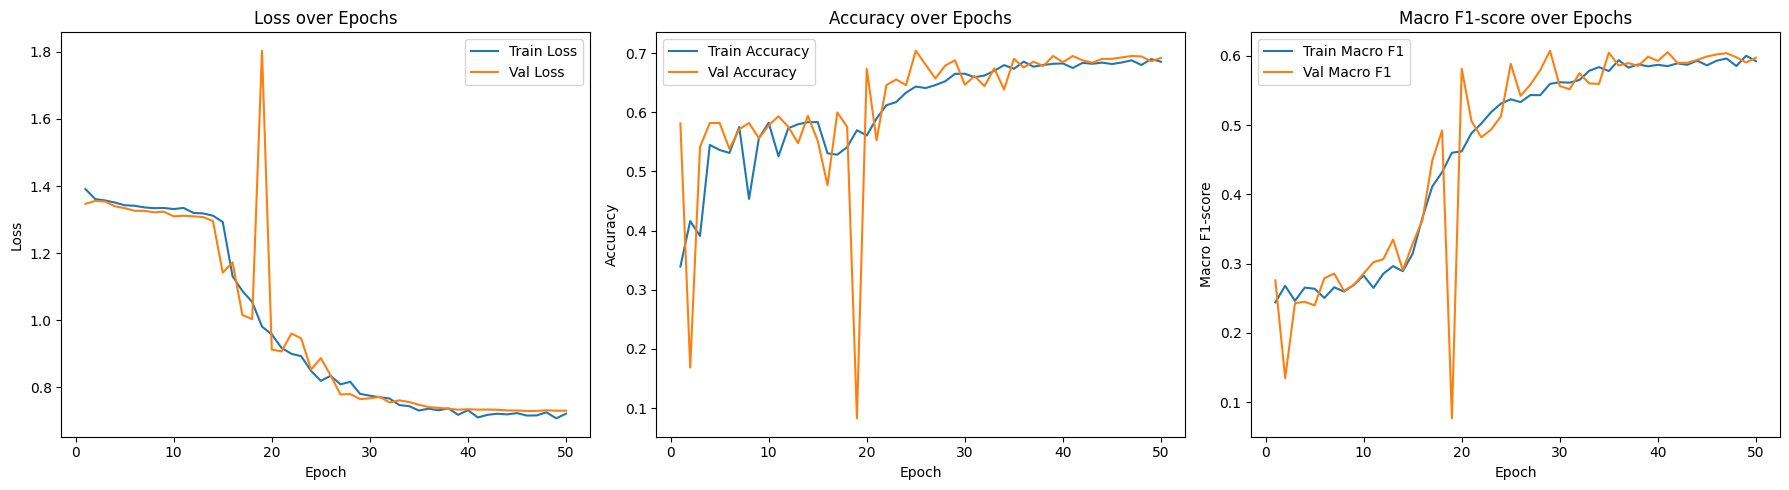

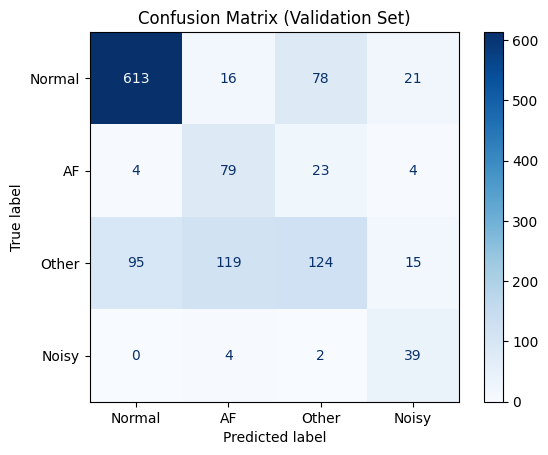

In [ ]:
# Performance Measure Visualizations

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Training History Visualization

def plot_training_history(history):
    epochs = np.arange(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(18, 5))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()

    # Macro F1
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history["train_f1"], label="Train Macro F1")
    plt.plot(epochs, history["val_f1"], label="Val Macro F1")
    plt.xlabel("Epoch")
    plt.ylabel("Macro F1-score")
    plt.title("Macro F1-score over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Confusion Matrix Visualization on Validation Set

def plot_confusion_matrix(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for signals, labels, lengths in dataloader:
            signals = [s.to(device) for s in signals]
            labels = labels.to(device)
            outputs = model(signals, lengths)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix (Validation Set)")
    plt.show()


class_names = ["Normal", "AF", "Other", "Noisy"]
plot_confusion_matrix(model, val_loader, device, class_names)
